## Imports


In [1]:
import os
import numpy as np
from numpy.lib.npyio import load
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


## Configure GPU and CUDA


In [2]:
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
config


gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}

## Helper methods


In [3]:
def loadData(path:str, labels:list, imgSize:tuple, validationSubset:bool=False) -> tf.data.Dataset:
    batch_size = 32
    subset = "validation" if validationSubset else "training"

    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode="grayscale",
        image_size=imgSize,
        batch_size=batch_size,
        validation_split=0.2,
        subset=subset,
        seed=123
    )

def loadTestData(path:str, labels:list, imgSize:tuple) -> tf.data.Dataset:
    batch_size = 32
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode="grayscale",
        image_size=imgSize,
        batch_size=batch_size,
    )

def loadImagesFromDir(basePath, imgSize:tuple):
    imagePaths = [basePath + imageName for imageName in os.listdir(basePath)]
    return [tf.keras.preprocessing.image.img_to_array(img) 
            for img in [tf.keras.preprocessing.image.load_img(
                    imagePath,
                    color_mode='grayscale', 
                    target_size=imgSize) for imagePath in imagePaths]]

def plotObjectsWithKeypoints(slice:int, images:list, labels:list, yPred:np.ndarray) -> None:
    plt.figure(figsize=(15,15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[9*slice+i]), cmap='gray')
        plt.scatter(yPred[9*slice+i][0::2]*imageH, yPred[9*slice+i][1::2]*imageH, marker='x', s=50, c='red')
        plt.scatter(labels[9*slice+i][0::2]*imageH, labels[9*slice+i][1::2]*imageH, marker='x', s=50, c='green')
        plt.axis("off")
    plt.show()

def plotTrainingHistory(history:tf.keras.callbacks.History, metric:str) -> None:
    loss = history.history[metric]
    val_loss = history.history['val_{}'.format(metric)]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.plot(epochs_range, loss, label='Training {}'.format(metric))
    plt.plot(epochs_range, val_loss, label='Validation {}'.format(metric))
    plt.legend(loc='upper right')
    plt.title('Training and Validation {}'.format(metric))
    plt.show()


## Load datasets


In [4]:
imageH = 160
imageW = 160
numFeatures = 16

dsTrain = loadData(path='resources/drill/train',
            labels=list(np.load('resources/drill/drill_keypoints_train.npy').reshape(294,16)),
            imgSize=(imageH,imageW),
            validationSubset=False)

dsValid = loadData(path='resources/drill/train',
                    labels=list(np.load('resources/drill/drill_keypoints_train.npy').reshape(294,16)),
                    imgSize=(imageH,imageW),
                    validationSubset=True)

dsTest = loadTestData(path='resources/drill/test',
                    labels=list(np.load('resources/drill/drill_keypoints_test.npy').reshape(66,16)),
                    imgSize=(imageH,imageW))



Found 294 files belonging to 1 classes.
Using 236 files for training.
Found 294 files belonging to 1 classes.
Using 58 files for validation.
Found 66 files belonging to 1 classes.


## Configure performance

 ```
 data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 ])
 .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) \
 ```

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dsTrain = dsTrain.cache().shuffle(300) \
    .prefetch(buffer_size=AUTOTUNE)

dsValid = dsValid.cache() \
    .prefetch(buffer_size=AUTOTUNE)



## Create basic model


In [6]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imageH, imageW, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numFeatures)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

## Train the model


In [7]:
epochs = 50
history = model.fit(dsTrain,
                validation_data=dsValid,
                epochs=epochs)


Epoch 1/50
8/8 [==============================] - 5s 218ms/step - loss: 0.1595 - accuracy: 0.0884 - val_loss: 0.0318 - val_accuracy: 0.3448
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0249 - accuracy: 0.2408 - val_loss: 0.0109 - val_accuracy: 0.4483
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0099 - accuracy: 0.3552 - val_loss: 0.0079 - val_accuracy: 0.5862
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0068 - accuracy: 0.5453 - val_loss: 0.0065 - val_accuracy: 0.6379
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0050 - accuracy: 0.6448 - val_loss: 0.0045 - val_accuracy: 0.7759
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0036 - accuracy: 0.6484 - val_loss: 0.0041 - val_accuracy: 0.7414
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0030 - accuracy: 0.6957 - val_loss: 0.0033 - val_accuracy: 0.7931
Epoch 8/50
8/8 [==========

## Inspect training accuracy


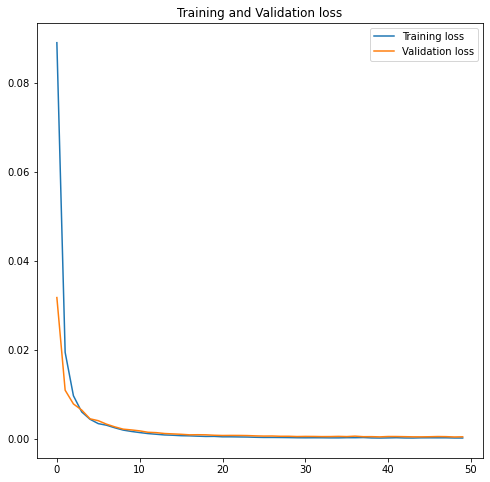

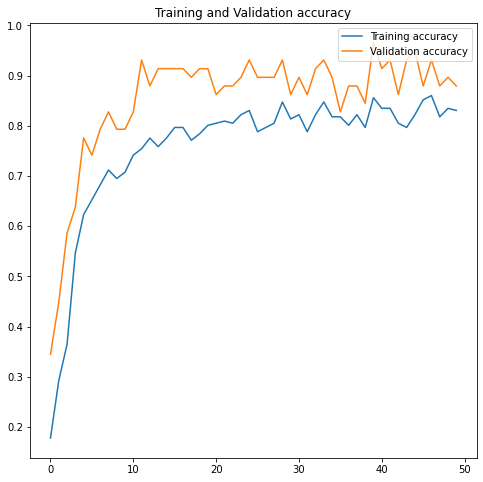

In [8]:
plotTrainingHistory(history, metric='loss')
plotTrainingHistory(history, metric='accuracy')


## Accuracy score model


In [9]:
test_loss, test_acc = model.evaluate(dsTest, verbose=2)


3/3 - 0s - loss: 4.5372e-04 - accuracy: 0.8333


# Predict


In [10]:
yPred = model.predict(dsTest)
images = loadImagesFromDir('resources/drill/test/masks/', (imageH, imageW))
labels = list(np.load('resources/drill/drill_keypoints_test.npy').reshape(66,16))


# Plot prediction results - GREEN: True, RED: Prediction


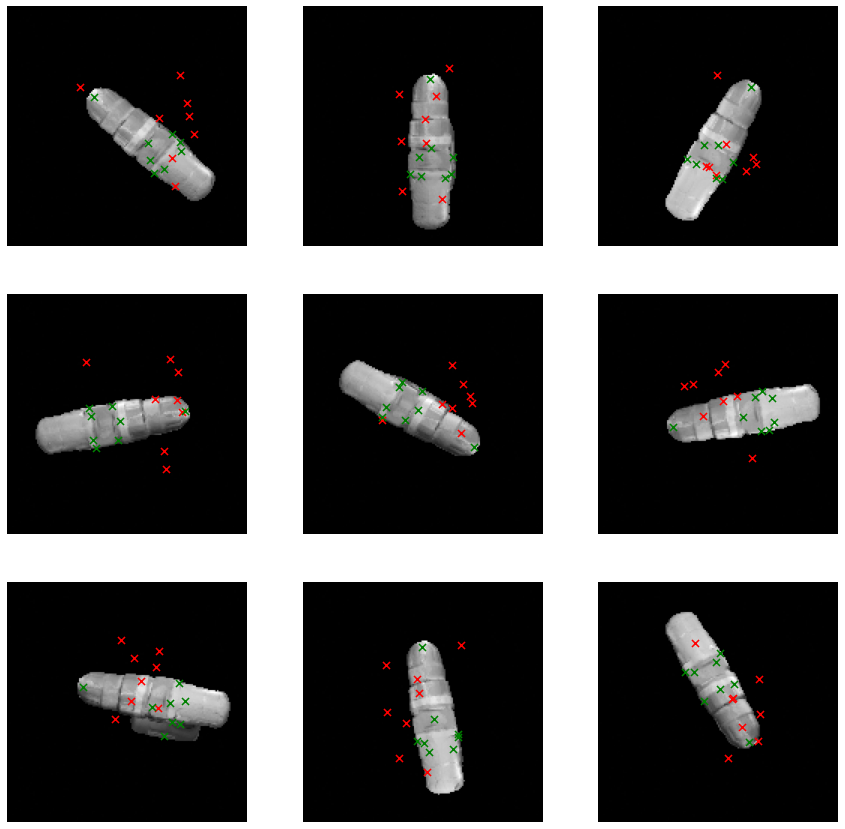

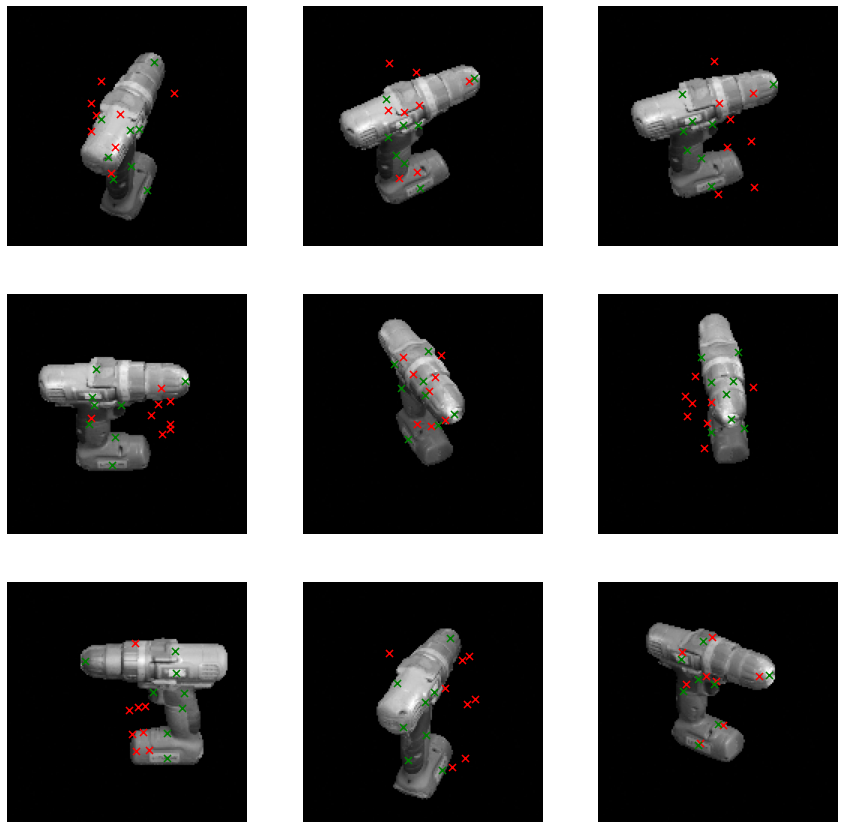

In [12]:
plotObjectsWithKeypoints(slice=0, images=images, labels=labels, yPred=yPred)
plotObjectsWithKeypoints(slice=3, images=images, labels=labels, yPred=yPred)

